# HoughCircles

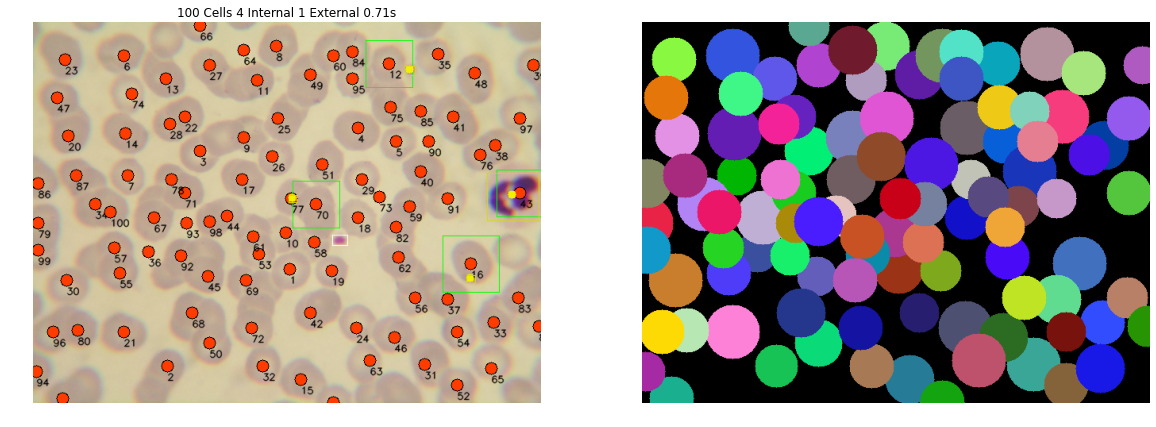

In [2]:
from ipynb.fs.full.general_functions import *
# https://www.programcreek.com/python/example/110725/cv2.pyrMeanShiftFiltering
import ipynb.fs.full.methods_names as methods

#demo_image = None

def hough_circles(gray,dp=2.4,minDist=20,param1=1,param2=31, minRadius=18, maxRadius=30):
#    global demo_image
    
    labeled_img_rgb = np.zeros((gray.shape[0],gray.shape[1],3), dtype='uint8')
    numLabels, labels, stats, centroids = 0, [], [], []
    
    
    #dst = cv2.pyrMeanShiftFiltering(imgBGR, 3, 5)
    #cimage = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    cimage = gray
    circles = cv2.HoughCircles(cimage, cv2.HOUGH_GRADIENT, 
                                dp=dp,
                                minDist=minDist, 
                                param1=param1, 
                                param2=param2, 
                                minRadius=minRadius, 
                                maxRadius=maxRadius)
    
    
    cellCount = 0
    
    if circles is not None:
        numLabels = len(circles[0])
        circles = np.uint16(np.around(circles))
        num = 0
        for i in circles[0, :]:
            num += 1
            x = int(i[0])
            y = int(i[1])
            R = int(i[2])+5
            
            #fill components props
            color = random_color()

            #define stats
            left = x - R
            left = left if x > R else 0
            top = y - R
            top = top if y > R else 0
            height = width = R*2
            area = pi*R**2
            stat = np.array([left,
                            top,
                            width,
                            height,
                            area], dtype='uint16') #area
            
            label = np.zeros((R*2,R*2),dtype='uint8')
            stats.append(stat)
            centroids.append((x,y))
            cv2.circle(label, (label.shape[0]//2, label.shape[1]//2), R, color, -1)
            labels.append(label)
            cv2.circle(labeled_img_rgb, (x, y), R, color, -1)
        
              
        return labeled_img_rgb, numLabels, labels, np.asarray(stats), centroids
    else:
        return labeled_img_rgb, numLabels, labels, np.asarray(stats), centroids

    
    
def hough_circles_method(path, validation_type, dp=2.4,minDist=20,param1=1,param2=31, mark_parasites=True):
    start = time.time()
    img = get_image(path=path,mode=1)
    
#    global demo_image
    demo_image = img
    
    imgGS = get_image(path=path)
    
#     img_blur = cv2.GaussianBlur(imgGS, (5,5), 0)
#     mask = cv2.Canny(image=img_blur, threshold1=15, threshold2=10)
    
#     plt.imshow(edges,cmap='gray')
#     plt.show()
    
    
    mask = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,301,0)
    #mask -= mask_residual
    
    mask = cv2.medianBlur(mask, 5)
    
    #plt.imshow(mask)
    #plt.show()
    par_mask, par_mask_dilated = hsv_par_mask(img)
    #par_mask = gs_parasite_mask(img)
    #remove parasites from otsu
    mask = remove_parasites(mask,par_mask)

    components = hough_circles(mask, dp, minDist, param1, param2)
    
    #plt.imshow(components[0])
    #plt.show()
    img, cells = mark_cells(img,mask=None,components=components,estimate=False,validation_type=validation_type)
    if mark_parasites:
        img, internal, external = parasites_mark(img,par_mask,None,components)
    else:
        internal, external = 0,0
        
    end = time.time()
    passTime = "%.2fs" % (end-start)
    #save results
    save_results(path, "Hough Circles",cells,internal,external, passTime, img, methods.HOUGH, validation_type)
    
    return (img, components[0]), (cells,internal,external,passTime)

if __name__ == '__main__':

    #PATH = "../PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    #PATH = "../blood_samples/samples/blood_smear_1.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    #PATH = "./blood_samples/samples/blood_smear_12.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    PATH = "../blood_samples/samples/blood_smear_8.JPG"
    images, stats = hough_circles_method(PATH, NO_VALIDATION)
    img, mask = images
    cells,internal,external,passTime = stats
    
    
    #m = unet_validation_mask(get_image(path=PATH,mode=1))
    #plt.imshow(m)
    #plt.show()

    fig, ax = plt.subplots(ncols=2, figsize=(20,20))
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[0].imshow(img)
    ax[1].imshow(mask)
    plt.show()
       